# Model Training Iteration 2
Model training here contains:
- Dataset only sourced from the internet 
- CustomDataGenerator to introduce data augmentation 
- Simple CNN architecture  

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow import keras
import seaborn as sns 
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

#from local package 
from voice_power_test.data_preprocessing import DataGenerator


## Constants

In [2]:
TARGET_WORD='marvin'
BACKGROUND_WORD="background"
SEED= 324234
SPEECH_DATA='audio_data'
train_ratio,val_ratio,test_ratio=0.8,0.1,0.1
BATCH_SIZE=32
VAL_BATCH_SIZE=8
IMG_WIDTH=43
IMG_HEIGHT=99
NOISE_FLOOR=0.1

In [3]:
os.chdir("../")

In [4]:
pwd

'c:\\Users\\abdul\\OneDrive\\Documents\\university\\4th year\\term2\\ENGR 501\\501_project\\data\\voice_power'

## Processing data 

Data Augmentation is introduced through the use of the class "DataGenerator" imported from modules/data_preprocessing.py. This is a custom data generator that at a high level performs the following: 
- Takes in filenames and reads the associated audio wav file
- Perform downsampling to solve class imbalance, every epoch the non-target class samples vary. 
- Isolates that speech component of the audio wave form and performs a random temporal shift
- Add random background noise that is also scaled randomly
- Computes the mel spectrogram of the processed audio 

This custom data generator is akin to the ImageDataGenerator from keras but is better suited for the needs of this project. 

In [5]:


def list_subfolders(folder_path):
    subfolders = [f.path[len(folder_path)+1:] for f in os.scandir(folder_path) if f.is_dir()]
    return subfolders

words = list_subfolders(SPEECH_DATA)
classes=[word for word in words if "_" not in word]

#extacting split dataset filenames
import pickle
with open('data/dict_split.pkl', 'rb') as handle:
    split_data = pickle.load(handle)


#Initializing custom data generator that augments the dataset.
datagen_train=DataGenerator(filenames=split_data['train'],
                            classes=classes,
                            data_folder=SPEECH_DATA,
                            noise_floor=NOISE_FLOOR,
                            target=TARGET_WORD,
                            batch_size=BATCH_SIZE,
                            training=True)

datagen_val=DataGenerator(filenames=split_data['val'],
                          classes=classes,
                          data_folder=SPEECH_DATA,
                          noise_floor=NOISE_FLOOR,
                          target=TARGET_WORD,
                          batch_size=VAL_BATCH_SIZE,
                          training=False)

In [6]:
datagen_train.__len__()

58

In [7]:
datagen_train.__getitem__(0)

(array([[[[-1.3495032 ],
          [-2.214073  ],
          [-1.8921684 ],
          ...,
          [-2.6387327 ],
          [-1.8995777 ],
          [-2.043761  ]],
 
         [[-1.6781726 ],
          [-2.5426605 ],
          [-2.3497179 ],
          ...,
          [-2.281443  ],
          [-2.3573382 ],
          [-2.497604  ]],
 
         [[-1.9109498 ],
          [-2.0845287 ],
          [-1.9533017 ],
          ...,
          [-2.8212504 ],
          [-2.1374567 ],
          [-2.3288414 ]],
 
         ...,
 
         [[-1.9264543 ],
          [-2.1226244 ],
          [-1.279105  ],
          ...,
          [-2.548904  ],
          [-2.5529146 ],
          [-2.9891849 ]],
 
         [[-2.4539251 ],
          [-2.4286072 ],
          [-1.5986154 ],
          ...,
          [-1.6658899 ],
          [-1.8674034 ],
          [-3.1235356 ]],
 
         [[-2.0129292 ],
          [-2.1592853 ],
          [-1.7086467 ],
          ...,
          [-2.2062597 ],
          [-1.938715  ],
    

## Model Achitecture

In [8]:
def build_model(kernal_reg=0.0001):
    tf.keras.backend.clear_session()
 
    model = Sequential([
        Conv2D(4, 3, 
               padding='same',
               activation='relu',
               kernel_regularizer=regularizers.l2(kernal_reg),
               name='conv_layer1',
               input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
        MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
        Conv2D(4, 3, 
               padding='same',
               activation='relu',
               kernel_regularizer=regularizers.l2(kernal_reg),
               name='conv_layer2'),
        MaxPooling2D(name='max_pooling2', pool_size=(2,2)),
        Flatten(),
        Dropout(0.2),
        Dense(
            40,
            activation='relu',
            kernel_regularizer=regularizers.l2(kernal_reg),
            name='hidden_layer1'
        ),
        Dense(
            1, 
            activation='sigmoid',
            kernel_regularizer=regularizers.l2(kernal_reg),
            name='output'
        )
    ])
    return model


In [9]:
model=build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 43, 99, 4)         40        
                                                                 
 max_pooling1 (MaxPooling2D)  (None, 21, 49, 4)        0         
                                                                 
 conv_layer2 (Conv2D)        (None, 21, 49, 4)         148       
                                                                 
 max_pooling2 (MaxPooling2D)  (None, 10, 24, 4)        0         
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 hidden_layer1 (Dense)       (None, 40)                3

## Training 

In [10]:
model=build_model()

epochs=60
validation_split=0.2
batch_size=16
validation_batch_size=8

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",save_weights_only=True,save_best_only=True)

In [11]:
history=model.fit(x=datagen_train,
                  validation_data=datagen_val, 
                  epochs=epochs,
                  callbacks=[checkpoint_cb,early_stopping_cb])


Epoch 1/60
58/58 [==============================] - 40s 668ms/step - loss: 0.6001 - accuracy: 0.6999 - val_loss: 0.5763 - val_accuracy: 0.7533
Epoch 2/60
58/58 [==============================] - 32s 550ms/step - loss: 0.5149 - accuracy: 0.7672 - val_loss: 0.6432 - val_accuracy: 0.6711
Epoch 3/60
58/58 [==============================] - 35s 611ms/step - loss: 0.4531 - accuracy: 0.8033 - val_loss: 0.4511 - val_accuracy: 0.7862
Epoch 4/60
58/58 [==============================] - 30s 515ms/step - loss: 0.4259 - accuracy: 0.8120 - val_loss: 0.4802 - val_accuracy: 0.7697
Epoch 5/60
58/58 [==============================] - 28s 492ms/step - loss: 0.4078 - accuracy: 0.8308 - val_loss: 0.4241 - val_accuracy: 0.7961
Epoch 6/60
58/58 [==============================] - 28s 490ms/step - loss: 0.4088 - accuracy: 0.8222 - val_loss: 0.4104 - val_accuracy: 0.8191
Epoch 7/60
58/58 [==============================] - 29s 506ms/step - loss: 0.4127 - accuracy: 0.8211 - val_loss: 0.4208 - val_accuracy: 0.8158

In [ ]:
np.roll

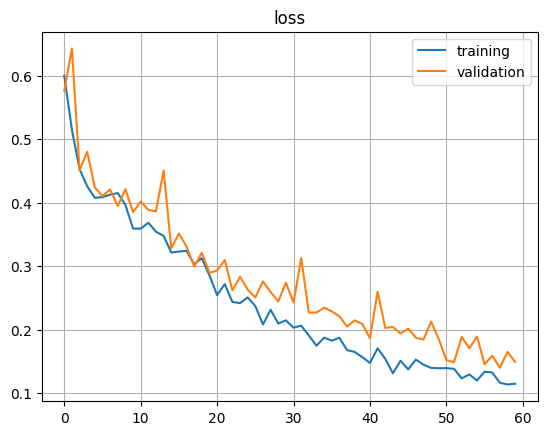

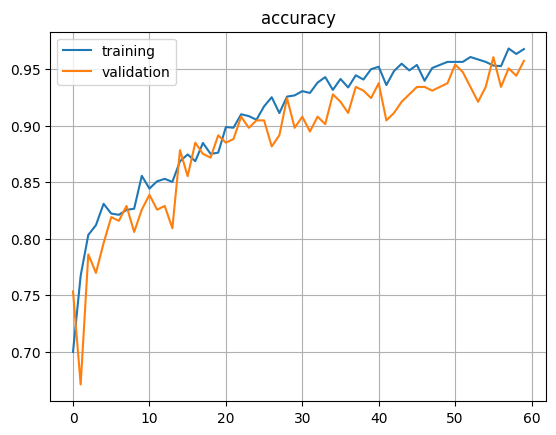

In [12]:
metrics=history.history
plt.plot(metrics['loss'],label='training')
plt.plot(metrics['val_loss'],label='validation')
plt.legend()
plt.title('loss')
plt.grid()
plt.show()

plt.plot(metrics['accuracy'],label='training')
plt.plot(metrics['val_accuracy'],label='validation')
plt.legend()
plt.title('accuracy')
plt.grid()
plt.show()


In [13]:
model.save('models/model_training3.keras')

## Evaluating training and validation set results 

There is a significant improvement to the validation error going from 90% to 97% as a result of introducing data augmentation through the use of the custom data generator. In earlier epoches the validation accuracy is higher than the training accuracy, this can be atributed to the use of drop out in the model architecture.

## Next Steps
- Develop code to perform the real-time capturing and classification of audio.
- Consider introducing background noise by itself as a non-target class for training. It could help real-time detection. 